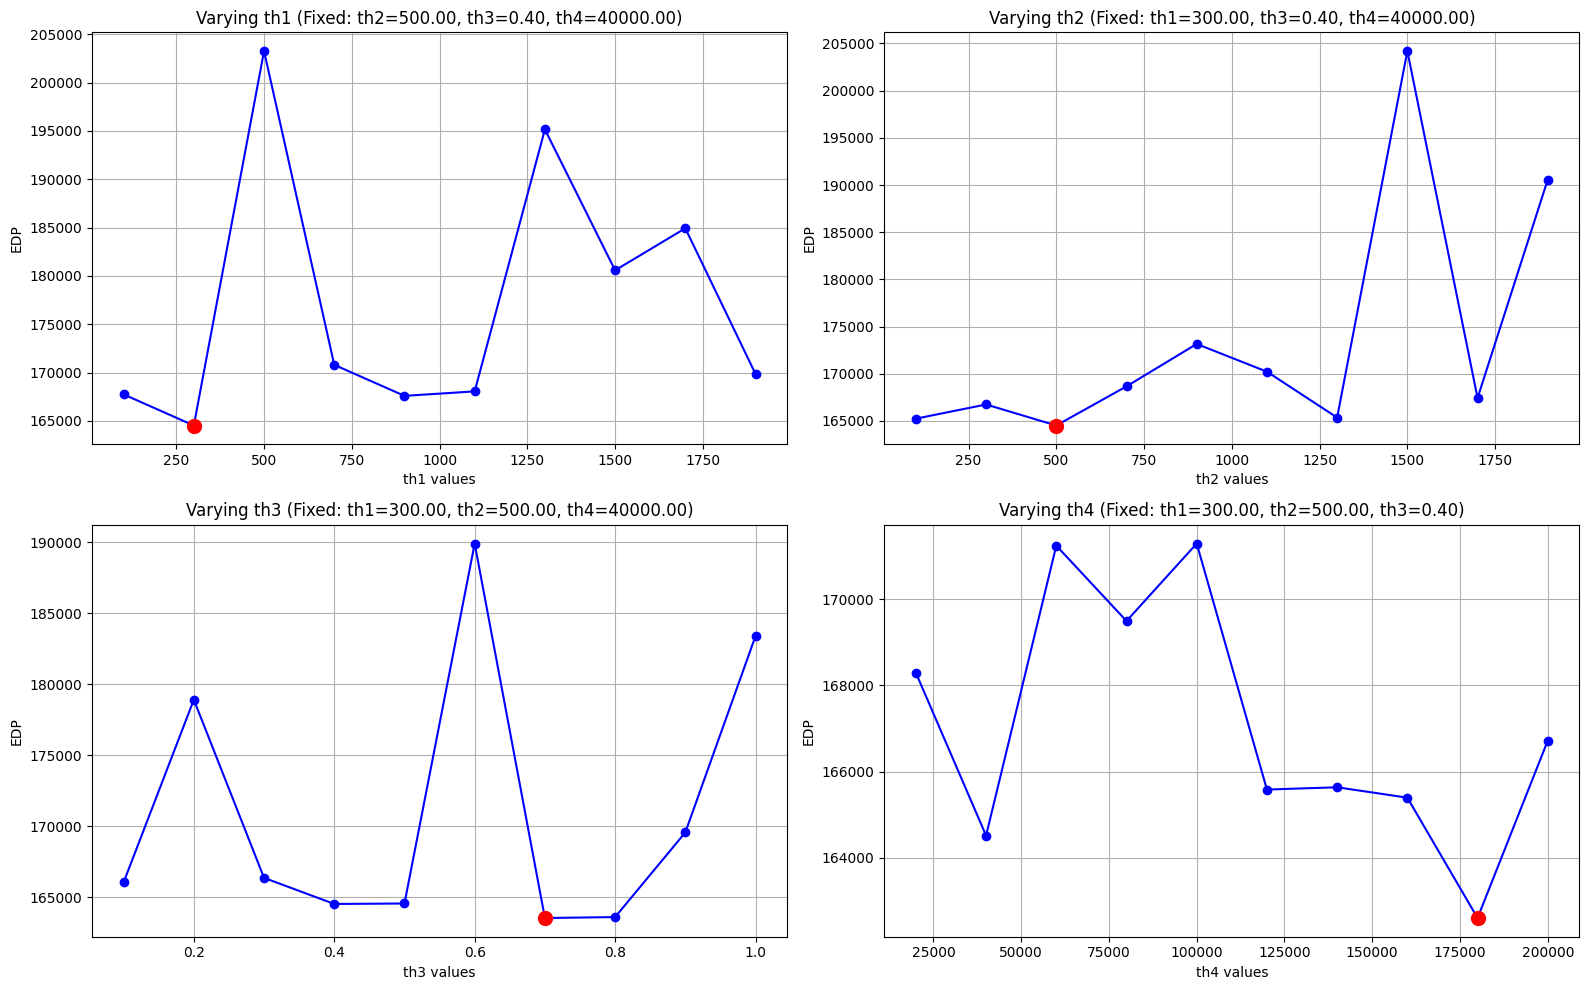

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

current_dir = "/home/cc/power/GPGPU/data/sensitivity/srad"

def extract_runtime(gpu_file):
    try:
        gpu_data = pd.read_csv(gpu_file)
        if "Time (s)" in gpu_data.columns:
            return gpu_data["Time (s)"].iloc[-1]
        else:
            print(f"Warning: 'Time (s)' column not found in {gpu_file}")
    except Exception as e:
        print(f"Error reading {gpu_file}: {e}")
    return None

def clean_data(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].apply(lambda x: max(x, 0))
    return df

def calculate_energy(cpu_file, gpu_file):
    try:
        gpu_data = pd.read_csv(gpu_file)
        gpu_data = clean_data(gpu_data, "GPU 0 Power (W)")
        time_gpu = gpu_data["Time (s)"].values
        power_gpu = gpu_data["GPU 0 Power (W)"].values
        energy_gpu = sum((power_gpu[i] + power_gpu[i - 1]) / 2 * (time_gpu[i] - time_gpu[i - 1]) for i in range(1, len(time_gpu)))

        cpu_data = pd.read_csv(cpu_file)
        cpu_data = clean_data(cpu_data, "Package Power (W)")
        time_cpu = cpu_data["Time (s)"].values
        power_cpu = cpu_data["Package Power (W)"].values
        energy_cpu = sum((power_cpu[i] + power_cpu[i - 1]) / 2 * (time_cpu[i] - time_cpu[i - 1]) for i in range(1, len(time_cpu)))

        return energy_cpu + energy_gpu

    except Exception as e:
        print(f"Error processing {cpu_file} and {gpu_file}: {e}")
        return None

energy_data = []

for file in os.listdir(current_dir):
    if "gpu" in file and file.endswith(".csv"):
        gpu_file_path = os.path.join(current_dir, file)
        cpu_file_path = gpu_file_path.replace("_gpu", "_cpu")

        if os.path.exists(cpu_file_path):
            runtime = extract_runtime(gpu_file_path)
            energy = calculate_energy(cpu_file_path, gpu_file_path)

            if runtime is not None and energy is not None:
                try:
                    parts = file.replace(".csv", "").split("_")
                    th1 = float(parts[-4])
                    th2 = float(parts[-3])
                    th3 = float(parts[-2])
                    th4 = float(parts[-1])
                    energy_data.append({
                        "File": file,
                        "Runtime (seconds)": runtime,
                        "Energy (Joules)": energy,
                        "th1": th1, "th2": th2, "th3": th3, "th4": th4
                    })
                except ValueError:
                    print(f"Could not parse thresholds in: {file}")

df_energy = pd.DataFrame(energy_data)

if not df_energy.empty:
    df_energy["EDP"] = df_energy["Runtime (seconds)"] * df_energy["Energy (Joules)"]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    threshold_names = ["th1", "th2", "th3", "th4"]
    fixed_sets = [("th2", "th3", "th4"), ("th1", "th3", "th4"), ("th1", "th2", "th4"), ("th1", "th2", "th3")]

    for i, fixed in enumerate(fixed_sets):
        varying = list(set(threshold_names) - set(fixed))[0]
        ax = axes[i]

        grouped = df_energy.groupby(list(fixed))
        selected_group = None
        for key, group in grouped:
            if group[varying].nunique() >= 10:
                selected_group = group.sort_values(by=varying).head(20)
                break

        if selected_group is not None:
            x_vals = selected_group[varying].values
            y_vals = selected_group["EDP"].values

            # Plot line and markers
            ax.plot(x_vals, y_vals, marker='o', linestyle='-', color='blue')

            # Highlight the point with the minimum ED2P
            min_idx = y_vals.argmin()
            ax.plot(x_vals[min_idx], y_vals[min_idx], marker='o', color='red', markersize=10)

            fixed_str = ", ".join(f"{f}={selected_group.iloc[0][f]:.2f}" for f in fixed)
            ax.set_title(f"Varying {varying} (Fixed: {fixed_str})")
            ax.set_xlabel(f"{varying} values")
            ax.set_ylabel("EDP")
            ax.grid(True)
        else:
            ax.set_title(f"Not enough values to vary {varying}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

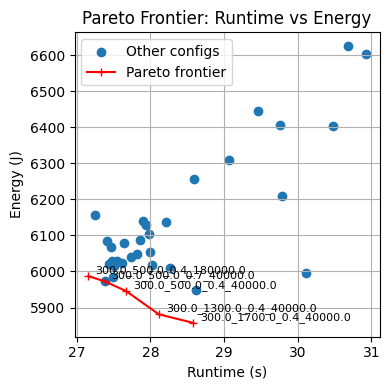

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

current_dir = "/home/cc/power/GPGPU/data/sensitivity/srad"

def extract_runtime(gpu_file):
    try:
        gpu_data = pd.read_csv(gpu_file)
        if "Time (s)" in gpu_data.columns:
            return gpu_data["Time (s)"].iloc[-1]
    except Exception as e:
        print(f"Error reading {gpu_file}: {e}")
    return None

def clean_data(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].apply(lambda x: max(x, 0))
    return df

def calculate_energy(cpu_file, gpu_file):
    try:
        gpu_data = pd.read_csv(gpu_file)
        gpu_data = clean_data(gpu_data, "GPU 0 Power (W)")
        time_gpu = gpu_data["Time (s)"].values
        power_gpu = gpu_data["GPU 0 Power (W)"].values
        energy_gpu = sum((power_gpu[i] + power_gpu[i - 1]) / 2 * (time_gpu[i] - time_gpu[i - 1]) for i in range(1, len(time_gpu)))

        cpu_data = pd.read_csv(cpu_file)
        cpu_data = clean_data(cpu_data, "Package Power (W)")
        time_cpu = cpu_data["Time (s)"].values
        power_cpu = cpu_data["Package Power (W)"].values
        energy_cpu = sum((power_cpu[i] + power_cpu[i - 1]) / 2 * (time_cpu[i] - time_cpu[i - 1]) for i in range(1, len(time_cpu)))

        return energy_cpu + energy_gpu

    except Exception as e:
        print(f"Error processing {cpu_file} and {gpu_file}: {e}")
        return None

energy_data = []

for file in os.listdir(current_dir):
    if "gpu" in file and file.endswith(".csv"):
        gpu_file_path = os.path.join(current_dir, file)
        cpu_file_path = gpu_file_path.replace("_gpu", "_cpu")

        if os.path.exists(cpu_file_path):
            runtime = extract_runtime(gpu_file_path)
            energy = calculate_energy(cpu_file_path, gpu_file_path)

            if runtime is not None and energy is not None:
                try:
                    parts = file.replace(".csv", "").split("_")
                    th1 = float(parts[-4])
                    th2 = float(parts[-3])
                    th3 = float(parts[-2])
                    th4 = float(parts[-1])
                    label = f"{th1}_{th2}_{th3}_{th4}"
                    energy_data.append({
                        "File": file,
                        "Runtime (s)": runtime,
                        "Energy (J)": energy,
                        "th1": th1, "th2": th2, "th3": th3, "th4": th4,
                        "Label": label
                    })
                except ValueError:
                    print(f"Could not parse thresholds in: {file}")

df = pd.DataFrame(energy_data)

# -----------------------------
# Pareto Frontier Computation
# -----------------------------
def is_pareto_efficient(data):
    """Returns a boolean mask of Pareto-efficient points."""
    data = np.array(data)
    is_efficient = np.ones(data.shape[0], dtype=bool)
    for i in range(data.shape[0]):
        if is_efficient[i]:
            # Remove points that are worse in both time and energy
            is_efficient[is_efficient] = np.any(data[is_efficient] < data[i], axis=1) | np.all(data[is_efficient] == data[i], axis=1)
            is_efficient[i] = True  # keep self
    return is_efficient

if not df.empty:
    plt.figure(figsize=(4, 4))

    runtimes = df["Runtime (s)"].values
    energies = df["Energy (J)"].values
    points = np.column_stack((runtimes, energies))

    is_pareto = is_pareto_efficient(points)
    pareto_points = df[is_pareto]
    non_pareto_points = df[~is_pareto]

    # Plot non-Pareto points
    plt.scatter(non_pareto_points["Runtime (s)"], non_pareto_points["Energy (J)"], label="Other configs")

    # Plot Pareto frontier
    pareto_sorted = pareto_points.sort_values("Runtime (s)")
    plt.plot(pareto_sorted["Runtime (s)"], pareto_sorted["Energy (J)"], color="red", label="Pareto frontier", marker="+")

    # Annotate the Pareto points with labels
    for _, row in pareto_sorted.iterrows():
        plt.annotate(row["Label"], (row["Runtime (s)"], row["Energy (J)"]), fontsize=8, xytext=(5, 2), textcoords='offset points')

    plt.xlabel("Runtime (s)")
    plt.ylabel("Energy (J)")
    plt.title("Pareto Frontier: Runtime vs Energy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
